# Multi-Class Performance

In [1]:
!pip install kaleido -q
!pip install sklearn -q
!pip install plotly -q

In [16]:
import requests
from collections import defaultdict

import kaleido
import plotly
import plotly.io
import plotly.io.kaleido
import plotly.express as px

# Confusion Matrix

In [17]:
import numpy 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

response = requests.get('https://farleyknight-digit-recog-app.herokuapp.com/training_data/confusion_matrix')
data = response.json()['data']

confusion_matrix = defaultdict(lambda: defaultdict(lambda: 0))

for example in data:
    pred = example['pred_label']
    true = example['true_label']
    confusion_matrix[pred][true] = example['count']

In [4]:
visualization_data = [[None]*10 for _ in range(10)]

for pred_index in range(10):
    for true_index in range(10):
        pred = str(pred_index)
        true = str(true_index)
        visualization_data[pred_index][true_index] = confusion_matrix[pred][true]

for row in visualization_data:
    print(row)

[5919, 0, 1, 0, 0, 0, 5, 0, 2, 3]
[0, 6737, 4, 0, 2, 0, 0, 12, 1, 1]
[0, 0, 5869, 20, 2, 45, 35, 2, 11, 1]
[0, 0, 0, 6097, 0, 8, 1, 0, 4, 0]
[0, 0, 2, 0, 5818, 0, 3, 2, 2, 15]
[0, 1, 28, 9, 0, 5352, 1, 1, 2, 1]
[3, 0, 40, 0, 5, 6, 5871, 0, 2, 0]
[0, 4, 11, 2, 2, 8, 0, 6239, 1, 3]
[0, 0, 1, 1, 2, 1, 2, 0, 5820, 7]
[1, 0, 2, 2, 11, 1, 0, 9, 6, 5918]


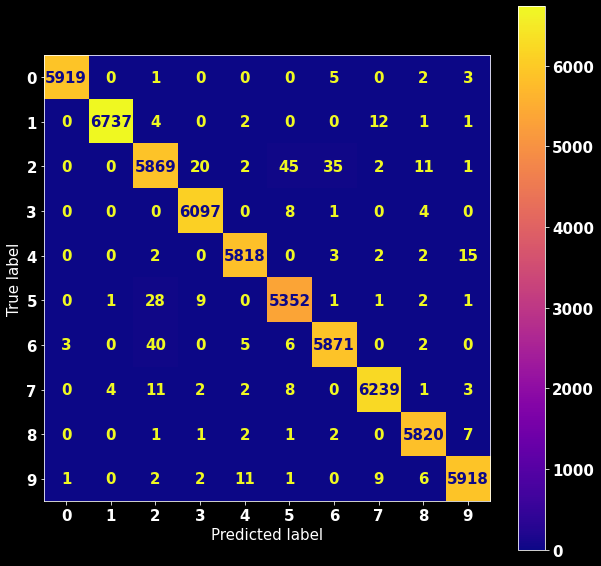

In [29]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10,10)

labels = [str(i) for i in range(10)]
disp = ConfusionMatrixDisplay(confusion_matrix=numpy.array(visualization_data), display_labels=labels)

disp.plot(cmap='plasma')
plt.margins(0.5)
plt.show()

# Classification Report

* sklearn's `classification_report`

In [21]:
response = requests.get('https://farleyknight-digit-recog-app.herokuapp.com/training_data/predictions?pageSize=60000')
data = response.json()['data']

In [23]:
def find_pred_label(row):
    pred_label = None
    max_score = 0
    for key in row.keys():
        if key.startswith('pred_'):
            score = row[key]
            if score > max_score:
                max_score = score
                pred_label = key.replace('pred_', '')
    return pred_label

for row in data:
    row['pred_label'] = find_pred_label(row)

In [26]:
from sklearn.metrics import classification_report
y_true = [row['true_label'] for row in data]
y_pred = [row['pred_label'] for row in data]
y_correct = [int(row['true_label'] == row['pred_label']) for row in data]
y_score = [row['pred_' + row['pred_label']] for row in data]
target_names = [str(index) for index in range(10)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

           0    0.99815   0.99932   0.99873      5923
           1    0.99704   0.99926   0.99815      6742
           2    0.98062   0.98506   0.98284      5958
           3    0.99787   0.99445   0.99616      6131
           4    0.99589   0.99589   0.99589      5842
           5    0.99203   0.98727   0.98964      5421
           6    0.99055   0.99206   0.99130      5918
           7    0.99506   0.99585   0.99545      6265
           8    0.99760   0.99470   0.99615      5851
           9    0.99462   0.99479   0.99471      5949

    accuracy                        0.99400     60000
   macro avg    0.99394   0.99387   0.99390     60000
weighted avg    0.99401   0.99400   0.99400     60000



# ROC Curve

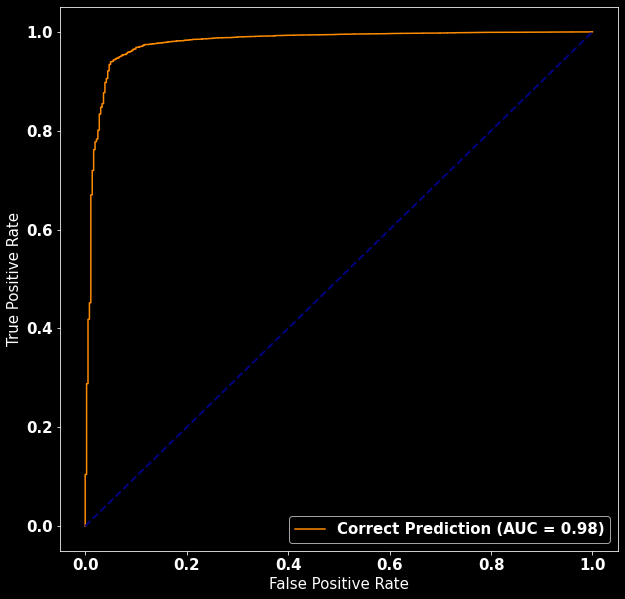

In [28]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.rcParams["figure.figsize"] = (10,10)


import numpy as np
from sklearn import metrics

false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(y_correct, y_score)
roc_auc = metrics.auc(false_pos_rate, true_pos_rate)
display = metrics.RocCurveDisplay(fpr=false_pos_rate, tpr=true_pos_rate, roc_auc=roc_auc,
                                  estimator_name='Correct Prediction')
display.plot(color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

NOTE: While the above may work for now, I think I want to get a different line for each class?

https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem

# PR Curve

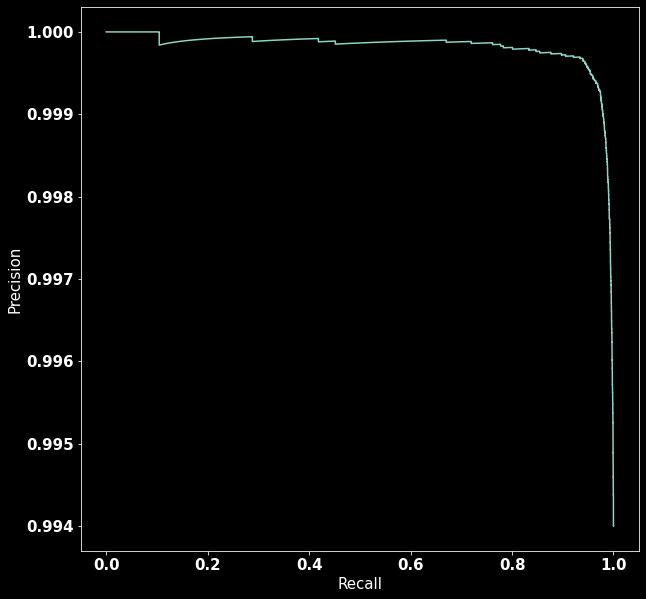

In [27]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.rcParams["figure.figsize"] = (10,10)

from sklearn.datasets import make_classification
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

precision, recall, _ = precision_recall_curve(y_correct, y_score)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

# Cross-Entropy Loss (aka Log Loss)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss


In [14]:
from sklearn.metrics import log_loss
log_loss(y_correct, y_score)

0.020720860350994

# Cohen’s Kappa

In [15]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_true, y_pred)

0.9933311470136887

# Class Prediction Error

Maybe use YellowBrick?
https://github.com/DistrictDataLabs/yellowbrick/blob/develop/examples/agodbehere/PytorchExample.ipynb